public publish
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2379819939516647/3141881435058130/8503730524814562/latest.html

Connexion

In [0]:
spark
sc = spark.sparkContext

Les imports

In [0]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

Chargement des données et vérification du schéma

In [0]:
# Lire le fichier JSON dans un DataFrame
filepath = "s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json"

df = spark.read.json(filepath)

# Afficher le schéma du DataFrame
df.printSchema()


root
 |-- data: struct (nullable = true)
 |    |-- appid: long (nullable = true)
 |    |-- categories: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ccu: long (nullable = true)
 |    |-- developer: string (nullable = true)
 |    |-- discount: string (nullable = true)
 |    |-- genre: string (nullable = true)
 |    |-- header_image: string (nullable = true)
 |    |-- initialprice: string (nullable = true)
 |    |-- languages: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- negative: long (nullable = true)
 |    |-- owners: string (nullable = true)
 |    |-- platforms: struct (nullable = true)
 |    |    |-- linux: boolean (nullable = true)
 |    |    |-- mac: boolean (nullable = true)
 |    |    |-- windows: boolean (nullable = true)
 |    |-- positive: long (nullable = true)
 |    |-- price: string (nullable = true)
 |    |-- publisher: string (nullable = true)
 |    |-- release_date: string (nullable = true)
 |    |-

In [0]:
# Afficher les premières lignes du DataFrame
df.show()

+--------------------+-------+
|                data|     id|
+--------------------+-------+
|{10, [Multi-playe...|     10|
|{1000000, [Single...|1000000|
|{1000010, [Single...|1000010|
|{1000030, [Multi-...|1000030|
|{1000040, [Single...|1000040|
|{1000080, [Multi-...|1000080|
|{1000100, [Single...|1000100|
|{1000110, [Multi-...|1000110|
|{1000130, [Single...|1000130|
|{1000280, [Single...|1000280|
|{1000310, [Multi-...|1000310|
|{1000360, [Multi-...|1000360|
|{1000370, [Single...|1000370|
|{1000380, [Single...|1000380|
|{1000410, [Single...|1000410|
|{1000470, [Single...|1000470|
|{1000480, [Single...|1000480|
|{1000500, [Multi-...|1000500|
|{1000510, [], 0, ...|1000510|
|{1000540, [Multi-...|1000540|
+--------------------+-------+
only showing top 20 rows



Il y a uniquement 2 colonnes donc il n'est pas nécessaire de vérifier l'absence de données.

Je vais créer une vue temporaire steam_games pour travailler en spark.SQL

In [0]:
# Créer une vue temporaire
df.createOrReplaceTempView("steam_games")

Quel éditeur a le plus de jeux ?


In [0]:
query = """
    SELECT 
		  count(distinct data.publisher) Nb_Editeurs
    FROM 
        steam_games
"""
 
# Exécuter la requête SQL
Nb_publisher = spark.sql(query).first()

# Afficher l'éditeur avec le plus de jeux
print(f"Le nombre d'éditeurs de jeux est de : {Nb_publisher['Nb_Editeurs']}.")


Le nombre d'éditeurs de jeux est de : 29966.


Nombre de jeux par éditeur.
On prend uniquement les éditeurs à lus de 99 jeux sinon il y en a trop.

In [0]:
query = """
    SELECT 
        data.publisher Editeurs, count(1) Nb_Jeux
    FROM 
        steam_games
    GROUP BY 
        data.publisher
    HAVING 
        count(1)>99
    ORDER BY 
        Nb_jeux DESC
"""

# Exécuter la requête SQL et récupérer toutes les lignes
editeurs = spark.sql(query).collect()
# Affichage des éditeurs avec 100 jeux et plus.
display(editeurs)

Editeurs,Nb_Jeux
Big Fish Games,422
8floor,202
SEGA,165
Strategy First,151
Square Enix,141
Choice of Games,140
Sekai Project,132
HH-Games,132
,132
Ubisoft,127


Databricks visualization. Run in Databricks to view.

In [0]:
query = """
    WITH genre AS
    (
        SELECT
            explode(split(data.genre, ', ')) genre
        FROM
            steam_games
        WHERE
            data.genre != ''
    )
    SELECT 
        Genre, count(1) Nb_Jeux
    FROM 
        genre
    GROUP BY 
        Genre
    ORDER BY 
        Nb_jeux DESC
"""

# Exécuter la requête SQL et récupérer toutes les lignes
genres = spark.sql(query).collect()
# Affichage des éditeurs avec 100 jeux et plus.
display(genres)


Genre,Nb_Jeux
Indie,39681
Action,23759
Casual,22086
Adventure,21431
Strategy,10895
Simulation,10836
RPG,9534
Early Access,6145
Free to Play,3393
Sports,2666


Nombre moyen d'avis par jeux

In [0]:
query = """
        SELECT
            AVG(data.positive+data.negative) Moyenne_Nb_Avis
        FROM
            steam_games
        Where 
            data.positive+data.negative>10000
 """
display(spark.sql(query))

Moyenne_Nb_Avis
64615.03316749585


La moyenne du nombre d'avis pour les jeux ayant au moins 10000 avis (ce qui exclue les jeux marginaux) est de 64615 avis.
Pour prendre en compte les 10 jeux au meilleur rapport pour les notes, nous allons prendre les jeux ayant au moins 40000 avis. Cela permettra d'éviter les jeux avec très peu d'avis et donc un ratio bien moins fiable. 

In [0]:
query = """
    SELECT
        data.name, round(data.positive/(data.positive+data.negative),2)*100 Pourcentage_note_positive,data.positive+data.negative  nb_avis, data.genre
    FROM
        steam_games
    WHERE 
        data.positive+data.negative >60000
    order by 
        Pourcentage_note_positive desc
    LIMIT 
        10
"""
result = spark.sql(query)
display(result)


name,Pourcentage_note_positive,nb_avis,genre
People Playground,99.0,144569,"Action, Casual, Indie, Simulation"
Hades,99.0,202789,"Action, Indie, RPG"
Vampire Survivors,99.0,131935,"Action, Casual, Indie, RPG"
Portal 2,99.0,309441,"Action, Adventure"
Stardew Valley,98.0,506841,"Indie, RPG, Simulation"
Helltaker,98.0,108165,"Adventure, Free to Play, Indie"
Wallpaper Engine,98.0,572127,"Casual, Indie, Animation & Modeling, Design & Illustration, Photo Editing, Utilities"
Dyson Sphere Program,98.0,65820,"Indie, Simulation, Strategy, Early Access"
Slime Rancher,98.0,99306,"Action, Adventure, Indie, Simulation"
The Binding of Isaac: Rebirth,98.0,215516,Action


Les 5 jeux avec les meilleurs ratios de notes parmi les jeux ayant au moins 40000 avis sont des jeux d'action dont les noms sont :
 - People Plyaground
 - Hades
 - Vampire Survivors
 - Portal 2
 - Stardew Valley


Répartition des jeux selon leur notation et les genres

In [0]:
query = """
    WITH genre AS
    (
        SELECT
            explode(split(data.genre, ', ')) genre, data.positive note_positive, data.negative note_negative
        FROM
            steam_games
        WHERE
            data.genre != ''
            and data.positive + data.negative > 0
    )
    SELECT 
        g.genre, sum(g.note_positive) total_positif, sum(g.note_negative) total_negative,round((sum(g.note_positive)/(sum(g.note_negative)+sum(g.note_positive))*5),1), count(1) Nb_Jeux
    FROM
        genre g
    GROUP BY 
        g.genre
    ORDER BY
        4 desc
"""

result = spark.sql(query)
display(result)


genre,total_positif,total_negative,"round(((sum(note_positive) / (sum(note_negative) + sum(note_positive))) * 5), 1)",Nb_Jeux
Photo Editing,577751,13745,4.9,104
Animation & Modeling,690765,26392,4.8,321
Design & Illustration,674057,27007,4.8,405
Utilities,739335,43503,4.7,681
Game Development,27461,3274,4.5,159
Audio Production,69118,9428,4.4,194
Video Production,111514,16362,4.4,246
Indie,32531023,4241234,4.4,39558
Racing,2340353,383691,4.3,2146
Web Publishing,33984,5238,4.3,89


In [0]:
query = """
    WITH genre AS
    (
        SELECT
            explode(split(data.genre, ', ')) genre, round(data.positive/(data.positive+data.negative)*5,0) Note_sur_5
        FROM
            steam_games
        WHERE
            data.genre != ''
            and data.positive + data.negative > 0
    ),
    genre_nb as
    (
        SELECT 
            explode(split(data.genre, ', ')) genre
        FROM 
            steam_games
    ),
    genre_garde AS
    (
        SELECT 
            genre, count(1) Nb
        FROM
            genre_nb
        GROUP BY
            genre
        ORDER BY
            NB DESC
            limit 16
    )
    SELECT 
        g.genre, g.Note_sur_5, count(1) Nb_Jeux
    FROM
        genre g
        INNER JOIN genre_garde gg ON g.genre=gg.genre
    GROUP BY 
        g.genre, note_sur_5
    ORDER BY
        g.genre
"""

result = spark.sql(query)
# display(result)

df = result.toPandas()

# Récupérer les éditeurs uniques
genres = df['genre'].unique()
nb_Lignes = (len(genres) + 1) // 2

fig = make_subplots(rows=nb_Lignes, cols=2, specs=[[{"type": "pie"} for _ in range(2)] for _ in range(nb_Lignes)],
                    subplot_titles=[f"Distribution des avis sur 5 pour le genre {genre}" for genre in genres])

# Itérer et visualiser
for i, genre in enumerate(genres):
    genre_data = df[df['genre'] == genre]

    total_games = genre_data['Nb_Jeux'].sum()
    category_order = sorted(genre_data['Note_sur_5'].unique())

    pie = px.pie(genre_data, values='Nb_Jeux', names='Note_sur_5', title=f"Distribution des avis sur 5 <br> pour le genre {genre}")

    fig.add_trace(pie.data[0], row=i // 2 + 1, col=i % 2 + 1)


fig.update_layout(height=300 * (len(genres) // 2 + len(genres) % 2), showlegend=True)

fig.show()

On va chercher le nombre de sorties de jeux par année. Nous prenons à partir de 2010 car les données ne sont pas assez importantes avant.

In [0]:
query = """
    SELECT 
        substring(data.release_date,1,4) Annee_Sortie, count(1) Nb_Jeux
    FROM 
        steam_games
    WHERE 
        cast(substring(data.release_date,1,4) as int) > 2009
    GROUP BY 
        substring(data.release_date,1,4)
    ORDER BY 
        Annee_Sortie
"""
display(spark.sql(query))

Annee_Sortie,Nb_Jeux
2010,288
2011,267
2012,345
2013,471
2014,1557
2015,2576
2016,4185
2017,6017
2018,7678
2019,6968


Databricks visualization. Run in Databricks to view.

Si le covid a eu un impact, ce serait plutôt de manière positive à la sortie des jeux. 2020 et 2021 sont les deux années avec le plus de jeux sorties.

Nombre de jeux par tarif. Au-delà, de 25€, il y a un pic tous els 10€ mais de plus en plus faible. J'ai privilégié l'affichage de la zone dense.

In [0]:
query = """
    SELECT
        data.price/100 Prix, count(1) Nb_Jeux
    FROM
        steam_games
    WHERE
        data.price/100  < 65
    GROUP BY
        data.price/100
    ORDER BY
        Nb_Jeux desc
"""

display(spark.sql(query))

Prix,Nb_Jeux
0.0,7780
4.99,6250
9.99,6126
0.99,5243
1.99,4193
2.99,3639
14.99,2878
19.99,2820
3.99,2530
6.99,1856


Databricks visualization. Run in Databricks to view.

Selon chacun des tarifs quel est le pourcentage moyen de réduction et cela représente quel pourcentage de jeux?
Pour avoir cette information nous allons devoir prendre en compte le nombre de propriétaires de jeux par réduction. Pour cela, nous prendrons en compte la moyenne des owners ( 50,000 .. 100,000 => 75000)

In [0]:
query = """
    WITH Repartition AS
    (
        SELECT
            distinct data.owners owners, 
            (to_number(translate(SPLIT(data.owners, ' .. ')[0], ',', ''), '999999999')+to_number(translate(SPLIT(data.owners, ' .. ')[1], ',', ''), '999999999'))/2 estim_owners
        FROM
            steam_games
    ),
    Nb_Jeux AS
    (
        SELECT 
            data.initialprice/100 Prix, sum(r.estim_owners) owners
        FROM 
            steam_games s
            INNER JOIN Repartition r on s.data.owners = r.owners
        GROUP BY 
            data.initialprice
    ),
    Nb_Jeux_Reduction AS
    (
        SELECT 
            data.initialprice/100 Prix, 
            data.discount Pct_Reduction, 
            sum(r.estim_owners) Nb_Reduc
        FROM 
            steam_games s
            INNER JOIN Repartition r ON s.data.owners=r.owners
       WHERE 
            data.initialprice!=data.price
        GROUP BY 
            data.initialprice,data.discount
    )
    SELECT
        j.prix, 
        round(
                sum(r.Pct_Reduction*r.Nb_Reduc)/j.owners
            ,2) Moy_Pct_Reduc, 
        ROUND(
                (
                    sum(r.Nb_Reduc) / j.owners * 100
                )
            , 2) Pct_Jeux_Avec_Reduction
    FROM
        Nb_Jeux j 
        INNER JOIN Nb_Jeux_Reduction r ON j.prix = r.prix
    GROUP BY 
        j.prix,j.owners
    ORDER BY 
        j.prix
"""

display(spark.sql(query))

prix,Moy_Pct_Reduc,Pct_Jeux_Avec_Reduction
0.9,5.03,10.89
0.98,45.94,93.75
0.99,5.47,10.98
1.0,0.6,2.99
1.29,12.5,25.00
1.49,5.56,11.11
1.99,2.69,4.61
2.49,0.47,0.59
2.99,4.77,7.37
3.99,3.63,5.58


Databricks visualization. Run in Databricks to view.

A voir le graphique on se rend compte que certains tarifs ne sont pas adaptés. Cela se traduit par une grosse remise sur un gros pourcentage de jeux. Le pourcentage de jeux avec une réduction est porpotionnel au pourcentage de réduction

In [0]:
query = """
    SELECT 
        data.discount Pct_Reduction, count(1) Nb_jeux
    FROM 
        steam_games s
    GROUP BY 
        data.discount
    ORDER BY 
        Nb_jeux desc
"""

display(spark.sql(query))

Pct_Reduction,Nb_jeux
0,53173
50,350
90,239
80,228
75,223
40,164
51,146
70,137
60,137
30,131


Via cette second erequette, on peut se rendre compte que la très grande majorité des jeux n'ont pas de réduction.

In [0]:
query = """
    SELECT 
        ROUND(AVG(data.discount),2) Pct_Reduction_Moyen
    FROM 
        steam_games s
"""
display(spark.sql(query))

Pct_Reduction_Moyen
2.6


Malgré de très haute réduction, on voit que le pourcentage moyen de réduction est très faible. Il est de 2.6%.

Quelles sont les langues les plus utilisées ?

In [0]:
# On récupère la liste des langues puis on compte combien de fois, elles sont présentes
query = """
    WITH langues AS 
    (
        SELECT
            explode(split(data.languages, ', ')) langue
        FROM
            steam_games
    )
    SELECT
        langue, 
        COUNT(1) Nb_jeux
    FROM
        langues
    GROUP BY
        langue
    ORDER BY 
        Nb_jeux desc
    LIMIT 10
"""

# Exécuter la requête SQL et afficher les résultats
result = spark.sql(query)
display(result, limit=10)

langue,Nb_jeux
English,55116
German,14019
French,13426
Russian,12922
Simplified Chinese,12782
Spanish - Spain,12233
Japanese,10368
Italian,9304
Portuguese - Brazil,6750
Korean,6599


Databricks visualization. Run in Databricks to view.

Y'a-t-il un lien entre l'âge requis et le prix ?

In [0]:
query = """     
    SELECT
        to_number(decode(data.required_age,null,0, '21+',21,'MA 15+',15,'7+',7,data.required_age),'999') age, 
        count(1) Nb_Jeux,
        min(data.price/100) prix_mini,
        round(avg(data.price/100),2) prix_moyen, 
        max(data.price/100) prix_maxi
    FROM
        steam_games
    WHERE 
        to_number(decode(data.required_age,null,0, '21+',21,'MA 15+',15,'7+',7,data.required_age),'999') < 25 
        and data.price < 20000
    GROUP BY
        data.required_age
    HAVING
        count(1)>5
    ORDER BY 
        age
"""

# # Exécuter la requête SQL et afficher les résultats
result = spark.sql(query)
display(result)


age,Nb_Jeux,prix_mini,prix_moyen,prix_maxi
0,55026,0.0,7.6,199.99
10,7,0.0,13.71,59.99
12,32,0.0,7.57,34.99
13,26,0.0,13.34,49.99
14,10,0.0,18.09,59.99
15,264,0.0,20.31,99.99
16,38,0.0,9.39,49.99
17,38,0.0,14.99,59.99
18,223,0.0,14.29,59.99


Databricks visualization. Run in Databricks to view.

On va évaluer les ages par langue pour les 10 langues les plus utilisés pour déterminer si la langue (potentiellement pays) a un impact

In [0]:
query = """     
    WITH genres AS 
    (
        SELECT
            explode(split(data.genre, ', ')) genre, 
            data.positive positive, 
            data.negative negative
        FROM
            steam_games
    )
    SELECT
        genre, COUNT(1) Nb_Jeux, 
        round(sum(positive)/count(1),2) Nb_Avis_Positif_Moyen, 
        round(sum(negative)/count(1),2) Nb_Avis_Negatif_Moyen, 
        round(sum(positive)/count(1),2)-round(sum(negative)/count(1),2) diff_pos_neg
    FROM
        genres g
    GROUP BY
        genre
    ORDER BY 
        Nb_Jeux desc
    LIMIT 
        15
"""

# # Exécuter la requête SQL et afficher les résultats
result = spark.sql(query)
display(result)

genre,Nb_Jeux,Nb_Avis_Positif_Moyen,Nb_Avis_Negatif_Moyen,diff_pos_neg
Indie,39681,819.81,106.88,712.93
Action,23759,2308.96,407.75,1901.21
Casual,22086,454.36,69.6,384.76
Adventure,21431,1385.35,263.78,1121.57
Strategy,10895,1230.19,219.68,1010.51
Simulation,10836,1437.1,221.53,1215.57
RPG,9534,2037.5,343.44,1694.06
Early Access,6145,705.39,152.35,553.04
Free to Play,3393,5517.9,1261.66,4256.24
Sports,2666,1106.45,271.14,835.3100000000001


Databricks visualization. Run in Databricks to view.

Répartition des genres par éditeurs. (pour les 10 plus gros éditeurs)

<Figure size 1008x432 with 0 Axes>

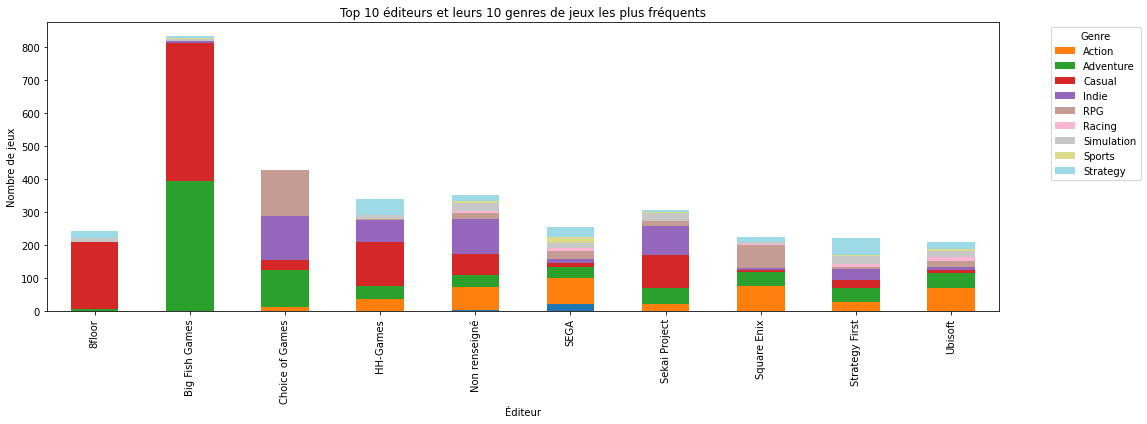

In [0]:
query = """
    WITH publisher_genre AS 
    (
        SELECT
            explode(split(data.genre, ', ')) genre, 
            data.publisher editeur
        FROM
            steam_games
    ),
    Top_10_editeur AS
    (
        SELECT 
            data.publisher editeur, 
            count(1) Nb_Jeux_Editeur
        FROM 
            steam_games
        GROUP BY 
            data.publisher
        HAVING 
            count(1) > 99
        ORDER BY
            Nb_Jeux_Editeur desc
        LIMIT
            10
    )
    SELECT 
        decode(e.editeur,'','Non renseigné',e.editeur) editeur, 
        p.genre, 
        e.Nb_Jeux_Editeur, 
        count(1) Nb_jeux
    FROM 
        Top_10_editeur e
        INNER JOIN publisher_genre p ON e.editeur=p.editeur
    GROUP BY
        e.editeur, p.genre, e.Nb_Jeux_Editeur
    ORDER BY 
        Nb_Jeux_Editeur DESC, Nb_jeux desc
"""

df = spark.sql(query).toPandas()

# Filtrer les 10 genres les plus fréquents globalement
top_genres = df.groupby('genre')['Nb_jeux'].sum().nlargest(10).index

df = df[df['genre'].isin(top_genres)]

pivot_df = df.pivot_table(
    index='editeur',
    columns='genre',
    values='Nb_jeux',
    aggfunc='sum',
    fill_value=0
)

# Définir une taille confortable
plt.figure(figsize=(14, 6))

# Tracer un histogramme empilé
pivot_df.plot(kind='bar', stacked=True, colormap='tab20', figsize=(16, 6))

plt.title("Top 10 éditeurs et leurs 10 genres de jeux les plus fréquents")
plt.ylabel("Nombre de jeux")
plt.xlabel("Éditeur")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


On va calculer la moyenne des ventes par genre en fonction du nombre de jeux.

In [0]:
query = """
    WITH Repartition AS
    (
        SELECT
            distinct data.owners owners, 
            (to_number(translate(SPLIT(data.owners, ' .. ')[0], ',', ''), '999999999')+to_number(translate(SPLIT(data.owners, ' .. ')[1], ',', ''), '999999999'))/2 estim_owners
        FROM
            steam_games
    ),
    Genre AS 
    (
        SELECT
            explode(split(data.genre, ', ')) genre,
            data.price/100  prix,
            r.estim_owners
        FROM
            steam_games s
            INNER JOIN Repartition r on s.data.owners=r.owners
    )
    SELECT
        g.genre,
        count(1)  Nb_Jeux,
        round(AVG(g.prix),2) Prix_Moyen,
        round(SUM(g.prix * g.estim_owners)/1000000000,2) Revenu_Estime_Milliard,
        round(AVG(g.prix * g.estim_owners)/1000000,2) Revenu_Moyen_Estime_Millions
    FROM
        Genre g
    GROUP BY
        genre
    ORDER BY
        Revenu_Estime_Milliard desc
    LIMIT 15
"""

display(spark.sql(query))

genre,Nb_Jeux,Prix_Moyen,Revenu_Estime_Milliard,Revenu_Moyen_Estime_Millions
Action,23759,7.73,58.76,2.47
Adventure,21431,8.01,37.25,1.74
Indie,39681,6.57,32.35,0.82
RPG,9534,9.04,27.17,2.85
Strategy,10895,8.4,20.15,1.85
Simulation,10836,9.09,18.77,1.73
Casual,22086,5.61,8.08,0.37
Massively Multiplayer,1460,5.0,5.93,4.06
Early Access,6145,8.75,5.46,0.89
Sports,2666,8.95,3.15,1.18


Databricks visualization. Run in Databricks to view.

Voyons voir au niveau du top 15 des jeux les plus rémunérateurs

In [0]:
query = """
   SELECT
        distinct data.name Jeu, 
        (to_number(translate(SPLIT(data.owners, ' .. ')[0], ',', ''), '999999999')+to_number(translate(SPLIT(data.owners, ' .. ')[1], ',', ''), '999999999'))/2 * data.price/100/1000000000 Revenu_Estime_Milliard
    FROM
        steam_games
    ORDER BY
        Revenu_Estime_Milliard desc
    LIMIT 15
"""

display(spark.sql(query))

Jeu,Revenu_Estime_Milliard
ELDEN RING,2.09965
New World,1.49925
Rust,1.39965
Grand Theft Auto V,1.0493
Cyberpunk 2077,0.89985
HITMAN 2,0.749925
Tom Clancy's Rainbow Six Siege,0.69965
Valheim,0.69965
Mount & Blade II: Bannerlord,0.59985
The Witcher 3: Wild Hunt,0.59985


In [0]:
query = """
SELECT
    sum(decode(data.platforms.linux,true,1,0)) Nb_Jeux, 
    'Linux' Plateforme
FROM
    steam_games
UNION ALL
SELECT 
    sum(decode(data.platforms.mac,true,1,0)), 
    'Mac'
FROM
    steam_games
UNION ALL
SELECT
    sum(decode(data.platforms.windows,true,1,0)), 
    'Windows'
FROM
    steam_games
"""

# # Exécuter la requête SQL et afficher les résultats
result = spark.sql(query)
display(result)

Nb_Jeux,Plateforme
8458,Linux
12770,Mac
55676,Windows


Databricks visualization. Run in Databricks to view.

In [0]:
query = """
    WITH genre_platform_data AS 
    (
    SELECT
            explode(split(data.genre, ', ')) genre,
            data.platforms.linux linux,
            data.platforms.mac mac,
            data.platforms.windows windows
        FROM
            steam_games
    ),
    genre_platform_counts AS 
    (
        SELECT
            genre,
            SUM(decode(linux,true,1,0)) Nb_Linux,
            SUM(decode(mac,true,1,0)) Nb_Mac,
            SUM(decode(windows,true,1,0)) Nb_Windows,
            COUNT(1) Total
        FROM
            genre_platform_data
        GROUP BY
            genre
    )
    SELECT
        genre,
        Nb_Linux,
        Nb_Mac,
        Nb_Windows,
        Total,
        ROUND((Nb_Linux / Total) * 100, 2) Pct_Linux,
        ROUND((Nb_Mac / Total) * 100, 2) Pct_Mac,
        ROUND((Nb_Windows / Total) * 100, 2) Pct_Windows,
        CASE
            WHEN Nb_Linux > Nb_Mac AND Nb_Linux > Nb_Windows THEN 'Linux'
            WHEN Nb_Mac > Nb_Linux AND Nb_Mac > Nb_Windows THEN 'Mac'
            WHEN Nb_Windows > Nb_Linux AND Nb_Windows > Nb_Mac THEN 'Windows'
            ELSE 'Pas_de_preference'
        END Platform_privilegiee
    FROM
        genre_platform_counts
    ORDER BY
        Total DESC
"""
result = spark.sql(query)
display(result)

# On voit dans le tableau, que Windows est toujours la plateforme privilégié.
# Afin de rendre la première visualisation plusparlante

genre,Nb_Linux,Nb_Mac,Nb_Windows,Total,Pct_Linux,Pct_Mac,Pct_Windows,Platform_privilegiee
Indie,6978,9935,39676,39681,17.59,25.04,99.99,Windows
Action,3379,4564,23755,23759,14.22,19.21,99.98,Windows
Casual,3305,5130,22082,22086,14.96,23.23,99.98,Windows
Adventure,3302,5039,21427,21431,15.41,23.51,99.98,Windows
Strategy,1826,3005,10892,10895,16.76,27.58,99.97,Windows
Simulation,1532,2439,10832,10836,14.14,22.51,99.96,Windows
RPG,1524,2248,9533,9534,15.98,23.58,99.99,Windows
Early Access,632,900,6145,6145,10.28,14.65,100.0,Windows
Free to Play,474,845,3391,3393,13.97,24.9,99.94,Windows
Sports,287,506,2665,2666,10.77,18.98,99.96,Windows


Databricks visualization. Run in Databricks to view.